In [ ]:
import numpy as np
import os
import json
import tensorflow as tf
import random
import itertools
!pip install mediapipe
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 2.8 MB/s 
Mounted at /content/drive


# Configure MediaPipe FaceMesh


In [ ]:
mp_face_mesh = mp.solutions.face_mesh

# Grab data for training model





This is grabbing the head pose video JSON instead of the eye data video.

In [ ]:
json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_pose/'
all_json_files = os.listdir(json_path)

json_data = {}
for filename in all_json_files:
  with open(json_path + filename, 'r') as file:
    s_data = json.load(file)
    json_data = {**json_data, **s_data}

In [ ]:
left_eye_point = set(sum(mp_face_mesh.FACEMESH_LEFT_EYE, ()))
right_eye_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_EYE, ()))
left_iris_point = set(sum(mp_face_mesh.FACEMESH_LEFT_IRIS, ()))
right_iris_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_IRIS, ()))

face_oval_point = set(sum(mp_face_mesh.FACEMESH_FACE_OVAL, ()))

#keypoints = left_eye_point.union(right_eye_point).union(left_iris_point).union(right_iris_point)

keypoints = left_eye_point.union(right_eye_point).union(face_oval_point)

keypoints = sorted(list(keypoints))

In [ ]:
face_oval_point

{10,
 21,
 54,
 58,
 67,
 93,
 103,
 109,
 127,
 132,
 136,
 148,
 149,
 150,
 152,
 162,
 172,
 176,
 234,
 251,
 284,
 288,
 297,
 323,
 332,
 338,
 356,
 361,
 365,
 377,
 378,
 379,
 389,
 397,
 400,
 454}

In [ ]:
keypoints

[7,
 10,
 21,
 33,
 54,
 58,
 67,
 93,
 103,
 109,
 127,
 132,
 133,
 136,
 144,
 145,
 148,
 149,
 150,
 152,
 153,
 154,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 172,
 173,
 176,
 234,
 246,
 249,
 251,
 263,
 284,
 288,
 297,
 323,
 332,
 338,
 356,
 361,
 362,
 365,
 373,
 374,
 377,
 378,
 379,
 380,
 381,
 382,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 397,
 398,
 400,
 454,
 466]

In [ ]:
train_x = []

for subject in json_data:
  subject_data = json_data[subject];
  
  for video in subject_data:
    for all_features in video['features']:
      train_x.append([all_features[i] for i in keypoints])
        

In [ ]:
len(train_x)

25752

# a VAE for compressing the head/eye position

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a mesh."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        kl_loss = 1/600 * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss')

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
len(train_x[0])

68

In [ ]:
latent_dim = 4
features = len(train_x[0])

vae_encoder_inputs = tf.keras.Input(shape=(features,3), name="vae_encoder_input")
vae_encoder_flatten = tf.keras.layers.Flatten(name="vae_flatten")(vae_encoder_inputs)
vae_encoder_dense_1 = tf.keras.layers.Dense(units=200, activation="relu", name="vae_dense_1")(vae_encoder_flatten)
vae_encoder_dense_2 = tf.keras.layers.Dense(units=100, activation="relu", name="vae_dense_2")(vae_encoder_dense_1)
vae_encoder_dense_3 = tf.keras.layers.Dense(units=50, activation="relu", name="vae_dense_3")(vae_encoder_dense_2)
z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(vae_encoder_dense_3)
z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(vae_encoder_dense_3)
vae_encoder = tf.keras.Model(inputs=vae_encoder_inputs, outputs=[z_mean, z_log_var])

vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 68, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 204)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          41000       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 100)          20100       ['vae_dense_1[0][0]']            
                                                                                              

In [ ]:
z = Sampling(name="vae_sampling")([z_mean, z_log_var])

vae_decoder_dense_1 = tf.keras.layers.Dense(50, activation="relu", name="vae_decoder_dense_1")(z)
vae_decoder_dense_2 = tf.keras.layers.Dense(100, activation="relu", name="vae_decoder_dense_2")(vae_decoder_dense_1)
vae_decoder_dense_3 = tf.keras.layers.Dense(200, activation="relu", name="vae_decoder_dense_3")(vae_decoder_dense_2)
vae_decoder_dense_4 = tf.keras.layers.Dense(features*3, activation=None, name="vae_decoder_dense_4")(vae_decoder_dense_3)
vae_decoder_outputs = tf.keras.layers.Reshape((features,3), name="vae_decoder_reshape")(vae_decoder_dense_4)

vae_decoder = tf.keras.Model(inputs=z, outputs=vae_decoder_outputs)

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 vae_decoder_dense_1 (Dense)  (None, 50)               250       
                                                                 
 vae_decoder_dense_2 (Dense)  (None, 100)              5100      
                                                                 
 vae_decoder_dense_3 (Dense)  (None, 200)              20200     
                                                                 
 vae_decoder_dense_4 (Dense)  (None, 204)              41004     
                                                                 
 vae_decoder_reshape (Reshap  (None, 68, 3)            0         
 e)                                                              
                                                           

In [ ]:
vae = tf.keras.Model(inputs=vae_encoder_inputs, outputs=vae_decoder_outputs, name="VAE")

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_encoder_input (InputLayer)  [(None, 68, 3)]     0           []                               
                                                                                                  
 vae_flatten (Flatten)          (None, 204)          0           ['vae_encoder_input[0][0]']      
                                                                                                  
 vae_dense_1 (Dense)            (None, 200)          41000       ['vae_flatten[0][0]']            
                                                                                                  
 vae_dense_2 (Dense)            (None, 100)          20100       ['vae_dense_1[0][0]']            
                                                                                                

In [ ]:
vae.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

In [ ]:
vae.fit(x=train_x, y=train_x, epochs=50)

Epoch 1/50
828/828 [==============================] - 4s 3ms/step - loss: 0.0097 - mean_squared_error: 0.0070 - kl_loss: 0.0027
Epoch 2/50
828/828 [==============================] - 3s 4ms/step - loss: 0.0048 - mean_squared_error: 0.0024 - kl_loss: 0.0024
Epoch 3/50
828/828 [==============================] - 3s 4ms/step - loss: 0.0045 - mean_squared_error: 0.0023 - kl_loss: 0.0022
Epoch 4/50
828/828 [==============================] - 3s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0022 - kl_loss: 0.0021
Epoch 5/50
828/828 [==============================] - 3s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0021 - kl_loss: 0.0020
Epoch 6/50
828/828 [==============================] - 3s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0019 - kl_loss: 0.0021
Epoch 7/50
828/828 [==============================] - 3s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0017 - kl_loss: 0.0022
Epoch 8/50
828/828 [==============================] - 3s 3ms/step - loss: 0.0039 - mean_squared_error: 0

In [ ]:
vae_encoder_fixed = tf.keras.Model(inputs=vae_encoder_inputs, outputs=z_mean)

vae_fixed = tf.keras.Sequential([vae_encoder_fixed, vae_decoder])

vae_fixed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 4)                 66354     
                                                                 
 model_1 (Functional)        (None, 68, 3)             66554     
                                                                 
Total params: 132,908
Trainable params: 132,908
Non-trainable params: 0
_________________________________________________________________


This plots the latent space all on one graph

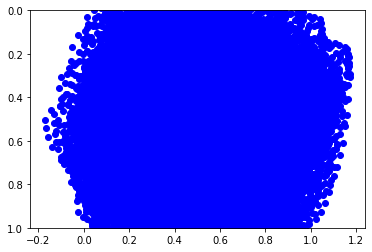

In [ ]:
min_val = -2
max_val = 2
breaks = 5

fig = plt.figure()

prediction_vals = list(itertools.product(np.linspace(min_val, max_val, breaks), repeat = latent_dim))

len(prediction_vals)

len(prediction_vals[0])

points = vae_decoder.predict(prediction_vals)

x_coords = points[:, :, 0]
y_coords = points[:, :, 1]

plt.ylim([1,0])

for i in range(len(x_coords)):
  plt.plot(x_coords[i,:], y_coords[i,:], 'bo')

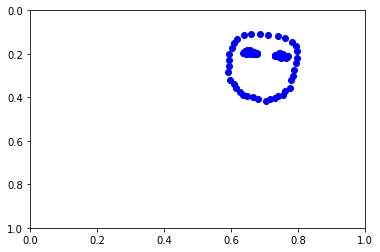

In [ ]:
points = vae_decoder.predict([[2,2,0,0]])

x_coords = points[:, :, 0]
y_coords = points[:, :, 1]

plt.ylim([1,0])
plt.xlim([0,1])
plt.plot(x_coords[0,:], y_coords[0,:], 'bo')

This plot shows that the reconstructions aren't quite good enough yet. Gets eyes in approximately the right location but orientation not right and outline not centered over original location.

But... this still has the random sampling component! **Need to create a network that doesn't randomly sample for Z but just uses the mean z value.**

(1.0, 0.0)

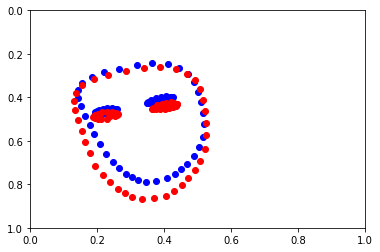

In [ ]:
example = np.array(train_x[100])
reconstructions = vae.predict(np.reshape(example, (1, -1, 3)))

plt.plot(example[:,0], example[:,1], 'bo')
plt.plot(reconstructions[0,:,0], reconstructions[0,:,1], 'ro')
plt.xlim([0,1])
plt.ylim([1,0])

This next chunk creates a model that bypasses the random sampling layer and uses only the `z_mean` values as the latent representation. 

Now we can rerun the prediction step and it will generate the same output each time. The predictions are much closer, but still not quite right.

(1.0, 0.0)

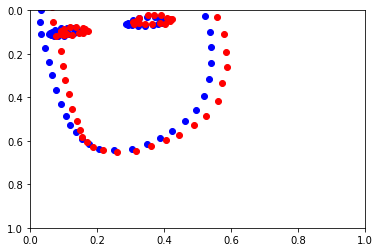

In [ ]:
example = np.array(train_x[500])
reconstructions = vae_fixed.predict(np.reshape(example, (1, -1, 3)))

plt.plot(example[:,0], example[:,1], 'bo')
plt.plot(reconstructions[0,:,0], reconstructions[0,:,1], 'ro')
plt.xlim([0,1])
plt.ylim([1,0])

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

vae_encoder_fixed.save('/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_'+timestamp)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_2022-07-11_16:53:53/assets
